# Demonstration of deconvolving PAX data
For details, see the manuscript

In [2]:
# import standard python modules:
import numpy as np 
import sys
sys.path.append('..')
%matplotlib auto
%load_ext tensorboard

# import custom python modules:
from pax_deconvolve.pax_simulations import simulate_pax
from pax_deconvolve.deconvolution import deconvolvers, assess_convergence
from pax_deconvolve import visualize

Using matplotlib backend: MacOSX


In [2]:
# Simulate some PAX data 

# perform simulations with 10^7 average number of detected electrons (over entire dataset):
log10_num_electrons = 7.0
rixs_model = 'schlappa'   # use RIXS model chosen to approximate that in Schlappa's paper
photoemission_model = 'ag'   # use Ag 3d core levels as model photoemission
num_simulations = 100     # number of recorded PAX spectra to simulate
energy_loss = np.arange(-8, 10, 0.01)   # energy loss values of RIXS spectrum to simulate over
impulse_response, pax_spectra, xray_xy = simulate_pax.simulate_from_presets(
    log10_num_electrons,
    rixs_model,
    photoemission_model,
    num_simulations,
    energy_loss
)

In [8]:
# Assess convergence of PAX data

# split data into training and validation sets for assessing convergence
split_point = int(len(pax_spectra['y'])*2.0/3.0)
pax_train = {
    'x': pax_spectra['x'],
    'y': pax_spectra['y'][:split_point]}
pax_validation_y = pax_spectra['y'][split_point:]

# Run convergence assessment
assess_convergence.run(
    impulse_response,
    pax_spectra,
    xray_xy,
    np.logspace(-3, -1, 10),
    1000,
    np.mean(pax_validation_y, axis=0)
)

KeyboardInterrupt: 

In [3]:
# Plot data which can be used to assess convergence (see manuscript):
%tensorboard --logdir logdir
# Since this is simulated data, 

Reusing TensorBoard on port 6006 (pid 33304), started 0:12:46 ago. (Use '!kill 33304' to kill it.)

In [9]:
#  Deconvolve PAX data, determining regulariation strength by cross validation of how well
#  we can estimate unseen data from the deconvolved result

# Set deconvolution settings
regularization_strengths = np.logspace(-3, -1, 10)  # Regularization strengths to test
iterations = 1000     # Number of iterations of deconvolution
cv_fold = 3   # Number of folds to use for cross validation

# Run deconvolution
deconvolver = deconvolvers.LRFisterGrid(
        impulse_response['x'],
        impulse_response['y'],
        pax_spectra['x'],
        regularization_strengths,
        iterations,
        xray_xy['y'],
        cv_fold
)
_ = deconvolver.fit(np.array(pax_spectra['y']))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.1s finished


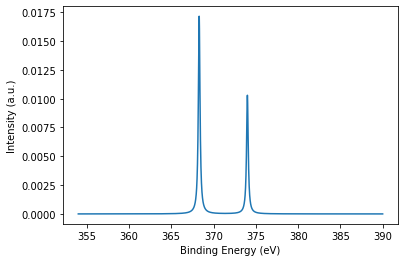

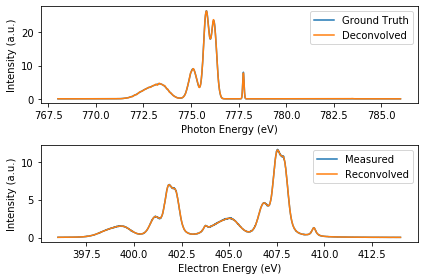

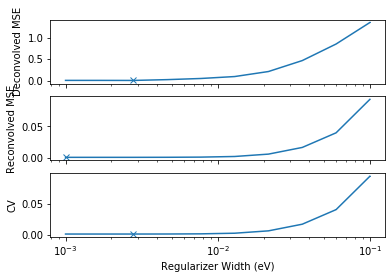

In [10]:
# Plot results
visualize.plot_photoemission(deconvolver)
visualize.plot_result(deconvolver)
visualize.plot_cv(deconvolver)

In [11]:
# get results for further processing
deconvolved_x = deconvolver.deconvolved_x    # Photon energies of deconvolved result
deconvolved_y = deconvolver.deconvolved_y_   # intensities of deconvolved result